In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# fix random seed
np.random.seed(42)
torch.manual_seed(42)

### Problem Formulation

We are interested in solving the Poisson Linear Inverse problem of the form:

\begin{equation}
    \min_x f(x) + g(x) \quad \text{ s.t. } \quad x>0
\end{equation}

using a Bregman Proximal Gradient Descent algorithm given by

\begin{equation}
    x_{k+1} = \argmin_z f(z) + \nabla g(x)^\top z + \frac{1}{\lambda} D_h(z,x),
\end{equation}

By choosing $h(x) = - e^\top \log (x)$, we have that 
\begin{align}
    D_h(z, x) &= h(z) - h(x) - \nabla h(x)^\top (z-x)
    \\
    &= e^\top \log(x) - \log(z) + \left(\frac{1}{x}\right)^\top(z - x) 
    \\
    &= \sum_{i=1}^n -\log\left(\frac{z_i}{x_i}\right) + \frac{z_i}{x_i} - 1
\end{align}

Moreover, we choose $g(x) = D_\phi(b || Ax)$ to be the Bregman Divergence based on the Boltzmann-Shannon entropy; that is $\phi(x) = x^\top \log(x)$, we have that its gradient is given by
\begin{equation}
    \nabla \phi(x) = e + \log(x)
\end{equation}
Thus, we have

\begin{align}
    g(x) &= \phi(b) - \phi(Ax) - \nabla \phi(Ax)^\top (b - Ax)
    \\
    &= b^\top \log(b) - (Ax)^\top \log(Ax) - (e + \log(Ax))^\top (b - Ax)
    \\
    &= b^\top \log(b) - (Ax)^\top \log(Ax) - e^\top(b-Ax) - \log(Ax)^\top b + \log(Ax)^\top Ax
    \\
    &= b^\top \log(b) - e^\top(b-Ax) - \log(Ax)^\top b
    \\
    &= e^\top Ax - \log(Ax)^\top b + b^\top \log(b) - e^\top b
    \\
    &= \sum_{i=1}^m a_i^\top x - b_i \log(a_i^\top x) + \text{constant}
\end{align}

Thus, our original problem can be formulated as

\begin{equation}
    \min_x \mu f(x) + \sum_{i=1}^m a_i^\top x - b_i \log(a_i^\top x)
\end{equation}

The NoLips algorithm does not require Lipschitz condition. And can thus be written as 

\begin{equation}
    x^+ = \argmin_z \mu f(z) + \nabla g(x_k)^\top z + \frac{1}{\lambda}\sum_{i=1}^n \frac{z_i}{x_i} - \log\left(\frac{z_i}{x_i}\right) - 1
\end{equation}

#### Choosing Sparse Regularization

Everything becomes separable and we arrive at the following iteration:
\begin{equation}
    x_i^+ \argmin_{z_i} \mu z_i + \nabla g(x)_i z_i + \frac{1}{\lambda} \left( \frac{z_i}{x_i} - \log\left( \frac{z_i}{x_i} \right) \right)
\end{equation}

In [2]:
m = 5
dim = m
n_zeros = int(dim/2)
# a = torch.rand(m,1)
# A = a @ a.T + 1e-1
A = torch.rand(m,m) + 1.0 # full rank
assert A.shape == (m,m)
x_true = torch.rand(dim) + 5.0
x_true[torch.randperm(dim)[:n_zeros]] = torch.zeros(n_zeros)

b = A@x_true 
b = torch.poisson(b)

x0 = torch.rand(dim) + 10
lam = 1e-5
mu = 1e-3

max_iters = int(2e4)

In [3]:
def f(x):
    # assumes x has shape n_samples by dim
    return torch.norm(x, p=1, dim=1)

def g(x, A=A, b=b, return_gradient=True):
    # assumes x has shape n_samples by dim
    # assumes A has shame m by dim
    # assumes b has shape m

    if return_gradient==True:
        x.requires_grad = True

    n_samples = x.shape[0]
    dim = x.shape[1]
    m = A.shape[0]
    assert A.shape[1] == dim

    Ax = A@x.permute(1,0)
    Ax = Ax.permute(1,0)
    assert Ax.shape == (n_samples, m)
    # print('Ax.shape = ', Ax.shape)

    blogAx = torch.log(Ax)*b
    # print('blogAx.shape = ', blogAx.shape)
    assert blogAx.shape == (n_samples, m)

    gx = torch.sum(Ax - blogAx , dim=1) + torch.sum(b * torch.log(b) - b) 

    if return_gradient==True:
        grad_gx = torch.autograd.grad(outputs=gx, inputs=x, grad_outputs=torch.ones(n_samples))[0]
        # detach gradient from x
        gx = gx.detach()
        grad_gx = grad_gx.detach()
        return gx, grad_gx
    else:
        return gx

### Perform BPGD using analytic formula:

In [4]:
xk = x0.clone()

loss = mu*f(xk.view(1,-1)) + g(xk.view(1,-1), return_gradient=False)
rel_err = torch.norm(xk - x_true)/torch.norm(x_true)
print('initial loss: ', "{:5.2e}".format(loss.item()), ', relerr: ', "{:5.2e}".format(rel_err.item()))

loss_hist = torch.zeros(max_iters+1)
rel_err_hist = torch.zeros(max_iters+1)

loss_hist[0] = loss.item()
rel_err_hist[0] = rel_err

for i in range(max_iters):

    _, gamma = g(xk.view(1,-1))
    assert gamma.shape == (1, dim)

    gamma = gamma.view(dim)
    assert gamma.shape == xk.shape
    x_new = xk / (1 + lam*mu*xk + lam*gamma*xk)

    # compute loss:
    loss = mu*f(x_new.view(1,-1)) + g(x_new.view(1,-1), return_gradient=False)
    rel_err = torch.norm(x_new - x_true)/torch.norm(x_true)
    assert x_true.shape == x_new.shape

    loss_hist[i+1] = loss
    rel_err_hist[i+1] = rel_err

    xk = x_new

    print('iter: ', (i+1), 
        ' loss: ', "{:5.2e}".format(loss.item()),
        ' relerr: ', "{:5.2e}".format(rel_err.item()),
    )

initial loss:  1.45e+02 , relerr:  1.89e+00
iter:  1  loss:  1.45e+02  relerr:  1.89e+00
iter:  2  loss:  1.45e+02  relerr:  1.89e+00
iter:  3  loss:  1.45e+02  relerr:  1.89e+00
iter:  4  loss:  1.45e+02  relerr:  1.88e+00
iter:  5  loss:  1.45e+02  relerr:  1.88e+00
iter:  6  loss:  1.44e+02  relerr:  1.88e+00
iter:  7  loss:  1.44e+02  relerr:  1.88e+00
iter:  8  loss:  1.44e+02  relerr:  1.88e+00
iter:  9  loss:  1.44e+02  relerr:  1.88e+00
iter:  10  loss:  1.44e+02  relerr:  1.88e+00
iter:  11  loss:  1.44e+02  relerr:  1.87e+00
iter:  12  loss:  1.43e+02  relerr:  1.87e+00
iter:  13  loss:  1.43e+02  relerr:  1.87e+00
iter:  14  loss:  1.43e+02  relerr:  1.87e+00
iter:  15  loss:  1.43e+02  relerr:  1.87e+00
iter:  16  loss:  1.43e+02  relerr:  1.87e+00
iter:  17  loss:  1.43e+02  relerr:  1.87e+00
iter:  18  loss:  1.42e+02  relerr:  1.86e+00
iter:  19  loss:  1.42e+02  relerr:  1.86e+00
iter:  20  loss:  1.42e+02  relerr:  1.86e+00
iter:  21  loss:  1.42e+02  relerr:  1.86e+00

#### Perform BPGD using Laplace's Method

To do this, we first note that the proximal formulation is completely separable:

\begin{align}
    &x^+ = \argmin_z \; \mu \|z\|_1 + \nabla g(x_k)^\top z + \frac{1}{\lambda}\sum_{i=1}^n \frac{z_i}{x_i} - \log\left(\frac{z_i}{x_i}\right) - 1
    \\
    \implies &x^+ = \argmin_z \sum_{i=1}^n \phi_i(z_i), \quad \text{ where } \quad \phi_i(z_i) = \mu |z_i| + \gamma_i z_i + \frac{1}{\lambda} \left(\frac{z_i}{x_i} - \log\left(\frac{z_i}{x_i} \right) \right)
    \\
    \implies &x_{i}^+ = \argmin_{z_i} \mu |z_i| + \gamma_i z_i + \frac{1}{\lambda} \frac{z_i}{x_i} - \log\left(\frac{z_i}{x_i} \right)
    \\
    \implies &x_{i}^+ \approx \dfrac{\int_{\mathbb{R}_{++}} \xi \exp\left(- \frac{\psi(\xi)}{\delta} \right) d\xi}{\int_{\mathbb{R}_{++}} \exp\left(- \frac{\psi(\xi)}{\delta} \right) d\xi}
\end{align}

where $\gamma_i = \nabla g(x)_i \quad $ and $ \quad \psi(\xi) = \mu |\xi| + \gamma_i \xi + \frac{1}{\lambda} \left(\frac{\xi}{x_i} - \log\left(\frac{\xi}{x_i} \right) \right)$.

In [5]:
def psi(z, xk, gamma, mu=mu, lam=lam):
  # assumes x has shape n_samples by dim
  # assumes xk has shape dim

  n_samples = z.shape[0]
  dim = z.shape[1]
  assert xk.shape[0] == z.shape[1]
  # assert xk has shape dim
  assert xk.dim() == 1

  frac_term = (z / xk)
  assert frac_term.shape == z.shape
  
  output = mu*torch.abs(z) + gamma*z + (1/lam) * (frac_term - torch.log(frac_term))
  assert output.shape == z.shape

  return output

In [6]:
def compute_prox(x, delta=1e-1, int_samples=100, alpha=1.0, linesearch_iters=0, device='cpu', lam=1e-1, domain=[1e-1, 50]):
  '''
      compute prox for the described problem
      input is a single vector x of size (dim)
  '''

  # assert x is a vector
  assert(x.dim() == 1)
  dim = x.shape[0]

  linesearch_iters +=1

  _, grad_gx = g(x.view(1,-1))
  grad_gx = grad_gx.view(dim)

  gamma = grad_gx.view(1, dim)

  # sample from Laplacian distribution
  z = domain[1] * torch.rand(int_samples, dim, device=device) + domain[0]
  psi_z = psi(z, x, gamma, mu=mu, lam=lam)
  assert psi_z.shape == z.shape

  w = torch.softmax(-psi_z*(alpha/delta), dim=0) # shape = n_samples x dim
  assert w.shape==z.shape

  softmax_overflow_check = (w < np.inf)
  if softmax_overflow_check.prod()==0.0:
    print('x = ', x)
    print('z = ', z)
    print('w = ', w)
    alpha = 0.5*alpha
    return compute_prox(x, delta=delta, int_samples=int_samples, alpha=alpha, linesearch_iters=linesearch_iters, device=device, lam=lam)
  else:
    prox_term = torch.sum(w*z, dim=0)
    assert prox_term.shape == xk.shape

    prox_overflow = (prox_term < np.inf)
    if prox_overflow.prod() == 0.0:
      print('prox overflowed: ', prox_term)
    assert(prox_overflow.prod() == 1.0)

    return prox_term, linesearch_iters

In [7]:
xk_smooth = x0.clone()

delta = 1e-1
domain = [0, 50]
int_samples = int(5e4)

loss = mu*f(xk_smooth.view(1,-1)) + g(xk_smooth.view(1,-1), return_gradient=False)
rel_err = torch.norm(xk_smooth - x_true)/torch.norm(x_true)
print('initial loss: ', "{:5.2e}".format(loss.item()), ', relerr: ', "{:5.2e}".format(rel_err.item()))

loss_hist_smooth = torch.zeros(max_iters+1)
rel_err_hist_smooth = torch.zeros(max_iters+1)

loss_hist_smooth[0] = loss.item()
rel_err_hist_smooth[0] = rel_err

for i in range(max_iters):

    _, gamma = g(xk_smooth.view(1,-1))
    assert gamma.shape == (1, dim)

    gamma = gamma.view(dim)
    assert gamma.shape == xk_smooth.shape
    x_new_smooth, _ = compute_prox(xk_smooth, delta=delta, int_samples=int_samples, alpha=1.0, linesearch_iters=0, device='cpu', lam=lam, domain=domain)
    true_prox = xk_smooth / (1 + lam*mu*xk_smooth + lam*gamma*xk_smooth)

    # compute loss:
    loss = mu*f(x_new_smooth.view(1,-1)) + g(x_new_smooth.view(1,-1), return_gradient=False)
    rel_err = torch.norm(x_new_smooth - x_true)/torch.norm(x_true)
    assert x_true.shape == x_new_smooth.shape

    loss_hist_smooth[i+1] = loss
    rel_err_hist_smooth[i+1] = rel_err

    xk_smooth = x_new_smooth

    print('iter: ', (i+1), 
        ' loss: ', "{:5.2e}".format(loss.item()),
        ' relerr: ', "{:5.2e}".format(rel_err.item()),
        ' prox_err: ', "{:5.2e}".format(torch.norm(xk_smooth - true_prox)/torch.norm(true_prox))
    )

initial loss:  1.45e+02 , relerr:  1.89e+00
iter:  1  loss:  1.45e+02  relerr:  1.89e+00  prox_err:  1.03e-04
iter:  2  loss:  1.45e+02  relerr:  1.89e+00  prox_err:  9.67e-05
iter:  3  loss:  1.45e+02  relerr:  1.89e+00  prox_err:  8.19e-05
iter:  4  loss:  1.45e+02  relerr:  1.88e+00  prox_err:  1.48e-04
iter:  5  loss:  1.45e+02  relerr:  1.88e+00  prox_err:  9.84e-05
iter:  6  loss:  1.44e+02  relerr:  1.88e+00  prox_err:  1.58e-04
iter:  7  loss:  1.44e+02  relerr:  1.88e+00  prox_err:  7.08e-05
iter:  8  loss:  1.44e+02  relerr:  1.88e+00  prox_err:  1.37e-04
iter:  9  loss:  1.44e+02  relerr:  1.88e+00  prox_err:  7.93e-05
iter:  10  loss:  1.44e+02  relerr:  1.88e+00  prox_err:  1.46e-04
iter:  11  loss:  1.44e+02  relerr:  1.87e+00  prox_err:  7.16e-05
iter:  12  loss:  1.43e+02  relerr:  1.87e+00  prox_err:  8.82e-05
iter:  13  loss:  1.43e+02  relerr:  1.87e+00  prox_err:  1.36e-04
iter:  14  loss:  1.43e+02  relerr:  1.87e+00  prox_err:  1.56e-04
iter:  15  loss:  1.43e+02 

### Perform BPGD using Laplace's Method with Variable Metric

In [8]:
def Dh(z, x):
    # returns Bregman Divergence based on the (variable metric) Burg entropy
    # assumes z has shape n_samples by dim
    # assumes x has shape dim
    
    n_samples = z.shape[0]
    dim = z.shape[1]
    assert z.shape == (n_samples, dim)
    assert x.shape == (dim,)

    Az = A@z.permute(1, 0)
    Az = Az.permute(1,0) # shape of Az is n_samples by m
    assert Az.shape == (n_samples, m)

    Ax = A@x
    assert Ax.shape == (m,)

    AT_over_Ax = (A.T) @ (1/(Ax))
    assert AT_over_Ax.shape == (dim,)

    z_minus_x = z - x
    assert z_minus_x.shape == (n_samples, dim)

    temp_grad_term = AT_over_Ax.view(1, dim) * z_minus_x

    assert temp_grad_term.shape == (n_samples, dim)

    grad_Dh_term = torch.sum(temp_grad_term, dim=1)
    # print('grad_Dh_term.shape = ', grad_Dh_term.shape)
    assert grad_Dh_term.shape == (n_samples,)


    logAx = torch.log(Ax)
    logAz = torch.log(Az)
    return torch.sum(logAx - logAz, dim=1) + grad_Dh_term

def temp_integrand(z, x, t):
    # assumes z has shape n_samples by dim
    # assumes x has shape dim
    
    n_samples = z.shape[0]
    dim = z.shape[1]
    assert z.shape == (n_samples, dim)
    assert x.shape == (dim,)

    n_samples = z.shape[0]
    dim = z.shape[1]
    assert x.shape == (dim,)

    _, grad_gx = g(x.view(1,-1), return_gradient=True)
    assert grad_gx.shape == (1, dim)
    grad_gx = grad_gx.view(-1)

    grad_gx_z = torch.sum(grad_gx*(z), dim=1)

    Dh_term = Dh(z, x)

    assert grad_gx_z.shape == (n_samples,)
    assert Dh_term.shape == (n_samples,)

    return grad_gx_z + t * Dh_term    

In [9]:
def compute_prox_var_metric(x, phi, mu, delta=1e-1, int_samples=100, alpha=1.0, linesearch_iters=0, device='cpu'):
  '''
      compute prox.
      input is a single vector x of size (dim x 1)
  '''
  assert(x.shape[1]==1)
  assert(x.shape[0]>=1)
  linesearch_iters +=1

  dim = x.shape[0]

  # sample from an exponential distribution with rate parameter mu/delta
  y = torch.distributions.exponential.Exponential(rate=mu/delta).sample((int_samples, dim)).to(device) # here y has shape (n_samples x dim)

  z = -phi(y)*(alpha/delta) # shape =  n_samples
  w = torch.softmax(z, dim=0) # shape = n_samples

  prox_term = torch.matmul(w.t(), y)
  prox_term = prox_term.view(-1,1)

  return prox_term, linesearch_iters

In [10]:
xk = x0.clone()
delta = mu*2
t = 1/lam
print_freq = 1

loss = mu*f(xk.view(1,-1)) + g(xk.view(1,-1), return_gradient=False)
rel_err = torch.norm(xk - x_true)/torch.norm(x_true)
print('initial loss: ', "{:5.2e}".format(loss.item()), ', relerr: ', "{:5.2e}".format(rel_err.item()))

loss_hist_bpgd_varmetric = torch.zeros(max_iters+1)
rel_err_hist_bpgd_varmetric = torch.zeros(max_iters+1)

loss_hist_bpgd_varmetric[0] = loss.item()
rel_err_hist_bpgd_varmetric[0] = rel_err

for i in range(max_iters):

    def integrand(z):
        return temp_integrand(z, xk, t)
    
    xk  = compute_prox_var_metric(xk.view(-1,1), integrand, mu, delta=delta, int_samples=int_samples, alpha=1.0, linesearch_iters=0, device='cpu')[0].view(-1)

    loss = mu*f(xk.view(1,-1)) + g(xk.view(1,-1), return_gradient=False)
    rel_err = torch.norm(xk - x_true)/torch.norm(x_true)
    loss_hist_bpgd_varmetric[i+1] = loss.item()
    rel_err_hist_bpgd_varmetric[i+1] = rel_err

    if i%print_freq==0:
        print('iter: ', i, ', loss: ', "{:5.2e}".format(loss.item()), ', relerr: ', "{:5.2e}".format(rel_err.item()), 'xk = ', xk[0:2])

initial loss:  1.45e+02 , relerr:  1.89e+00
iter:  0 , loss:  1.17e+02 , relerr:  2.32e+00 xk =  tensor([25.0769,  5.8749])
iter:  1 , loss:  6.83e+01 , relerr:  1.43e+00 xk =  tensor([6.8126, 2.4138])
iter:  2 , loss:  6.28e+01 , relerr:  1.45e+00 xk =  tensor([ 8.9596, 10.0685])
iter:  3 , loss:  6.06e+01 , relerr:  1.50e+00 xk =  tensor([15.3629,  6.2091])
iter:  4 , loss:  5.91e+01 , relerr:  1.09e+00 xk =  tensor([7.8951, 0.7346])
iter:  5 , loss:  6.01e+01 , relerr:  1.86e+00 xk =  tensor([2.7643, 4.3871])
iter:  6 , loss:  5.96e+01 , relerr:  1.65e+00 xk =  tensor([2.4212, 2.5750])
iter:  7 , loss:  6.00e+01 , relerr:  1.41e+00 xk =  tensor([8.7535, 0.4879])
iter:  8 , loss:  5.29e+01 , relerr:  1.74e+00 xk =  tensor([6.4226, 0.1762])
iter:  9 , loss:  4.96e+01 , relerr:  2.11e+00 xk =  tensor([0.0427, 5.6694])
iter:  10 , loss:  4.62e+01 , relerr:  1.16e+00 xk =  tensor([12.2553,  1.9676])
iter:  11 , loss:  4.19e+01 , relerr:  1.03e+00 xk =  tensor([10.6012,  2.9376])
iter:  1

<Figure size 640x480 with 0 Axes>

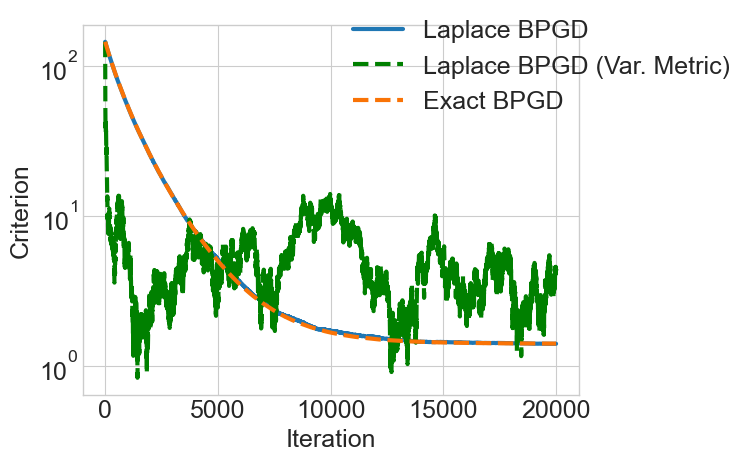

In [11]:
import matplotlib.pyplot as plt

# plotting parameters
title_fontsize = 22
fontsize       = 18
fig1 = plt.figure()
my_blue = '#1f77b4'
my_orange = '#F97306'

fig1 = plt.figure()
plt.style.use('seaborn-v0_8-whitegrid')
ax = plt.axes()

ax.semilogy(loss_hist_smooth, linewidth=3, color=my_blue, markersize=8)
ax.semilogy(loss_hist_bpgd_varmetric, linewidth=3, markersize=10, color = 'green', linestyle='--')
ax.semilogy(loss_hist, linewidth=3, markersize=10, color = my_orange, linestyle='--')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
legend_str1 = r'Laplace BPGD'
legend_str2 = r'Laplace BPGD (Var. Metric)'
legend_str3 = r'Exact BPGD'
ax.legend([legend_str1, legend_str2, legend_str3],fontsize=fontsize, bbox_to_anchor=(0.5, 0.7))
ax.tick_params(labelsize=fontsize, which='both', direction='in')

# add x label
ax.set_xlabel('Iteration', fontsize=fontsize)
# add y label
ax.set_ylabel('Criterion', fontsize=fontsize)
save_str = 'BPGD_Poisson_IP_loss_Full_Rank.pdf'
fig1.savefig(save_str, dpi=50 , bbox_inches="tight", pad_inches=0.0)

In [15]:
import csv

# get loss_hist every 100 iterations
loss_hist_coarse = loss_hist[0:max_iters+1:100]
loss_hist_smooth_coarse = loss_hist_smooth[0:max_iters+1:100]
loss_hist_bpgd_varmetric_coarse = loss_hist_bpgd_varmetric[0:max_iters+1:100]

with open('bpgd_loss_hist_all_three_full_rank.csv', mode='w') as file:
    writer = csv.writer(file)
    # write in a row for each iteration
    for i in range(len(loss_hist_coarse)):
        writer.writerow([loss_hist_coarse[i].item(), loss_hist_smooth_coarse[i].item(), loss_hist_bpgd_varmetric_coarse[i].item()])